In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'    
sns.set()
warnings.filterwarnings('ignore')
random_seed = 200

Using TensorFlow backend.


In [11]:
df = pd.read_csv('winequality.csv')
df = df[(df['quality'] < 5) | (df['quality'] > 6)]

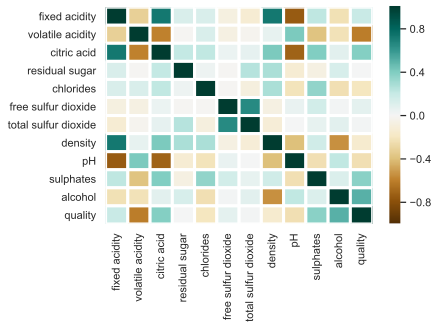

In [12]:
_ = sns.heatmap(df.corr(), cmap="BrBG", linewidths = 3, vmin = -1, vmax = 1, annot = False)

In [13]:
test_precent = 0.2
train_precent = 1.0 - test_precent
train_data = df.sample(frac=train_precent, random_state=random_seed)
test_data = df.drop(train_data.index)
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        average = x[feature_name].mean()
        std = x[feature_name].std()
        result[feature_name] = (x[feature_name] - average) / std
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)
normalized_train_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1001,0.635793,-0.567719,0.233595,-0.824436,-0.476906,1.682782,0.410629,0.249510,-0.344940,0.567602,-0.563599,0.452601
369,0.388110,-0.921642,0.925117,-0.166844,-0.145016,-0.773514,-0.593303,-0.011072,-0.714635,2.338235,0.701423,0.452601
1098,-0.305402,-0.744681,0.556305,-0.386041,2.800503,-0.871766,-0.662540,-1.230222,-1.022715,0.510485,1.153216,0.452601
1279,0.586256,-0.788921,0.279696,-0.678304,-0.393934,-1.068269,-0.904868,-0.662527,-1.084331,-0.860328,0.249629,0.452601
1408,-0.255865,-0.833161,0.141392,-0.312976,-0.684337,2.075789,0.618339,-0.569462,-0.283324,1.652829,1.062857,0.452601


In [14]:
y_label='quality'
train_x = normalized_train_data.drop(y_label, axis = 1)
train_y = normalized_train_data[y_label]
test_x = normalized_test_data.drop(y_label, axis = 1)
test_y = normalized_test_data[y_label]

In [15]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 400


def show_history(history):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df['log_loss_1'] = np.log(history_df['loss'] + 1)
    sns.lineplot(data = history_df, y='log_loss_1', x='epoch')
    plt.gca().set_ylim(bottom=0)

def nn_mse(X,y):
    inputs_len = len(X.columns)
    input1 = Input(shape=(inputs_len,))
    hidden1 = Dense(inputs_len, activation='relu')(input1)
    hidden2 = Dense(inputs_len, activation='relu')(hidden1)
    out1 = Dense(1)(hidden2)
    model = Model(inputs=input1, outputs=out1)
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X, y, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])
    show_history(history)
    predicted = model.predict(X).flatten()
    expected = y
    return mean_squared_error(expected, predicted)

In [16]:
def fit_predict_mse_test(regressor, train_X, train_Y, test_X, test_Y):
    regressor.fit(train_X,train_Y)
    expected = regressor.predict(test_X)
    return mean_squared_error(expected, test_Y)
def fit_predict_mse_train(regressor, train_X, train_Y, test_X, test_Y):
    regressor.fit(train_X,train_Y)
    expected = regressor.predict(train_X)
    return mean_squared_error(expected, train_Y)

In [17]:
results_df = pd.DataFrame(columns=['Classifier', 'MSE'])
def predict_and_add_to_df(data_frame, name, regressor):
    return data_frame.append({'Classifier': name, 'MSE': fit_predict_mse_test(regressor, train_x, train_y, test_x, test_y)}, ignore_index = True)
    
#results_df = results_df.append({'Classifier': 'NN', 'MSE': nn_mse(X,y)}, ignore_index = True)
results_df = predict_and_add_to_df(results_df, 'KNN5', KNeighborsRegressor(5))
results_df = predict_and_add_to_df(results_df, 'KNN7', KNeighborsRegressor(7))
results_df = predict_and_add_to_df(results_df, 'KNN9', KNeighborsRegressor(9))
results_df = predict_and_add_to_df(results_df, 'Linear', LinearRegression())
results_df = predict_and_add_to_df(results_df, 'SVM', SVR())
results_df = predict_and_add_to_df(results_df, 'DTree2', DecisionTreeRegressor(max_depth = 2))
results_df = predict_and_add_to_df(results_df, 'DTree3', DecisionTreeRegressor(max_depth = 3))
results_df = predict_and_add_to_df(results_df, 'DTree4', DecisionTreeRegressor(max_depth = 4))
results_df = predict_and_add_to_df(results_df, 'DTree5', DecisionTreeRegressor(max_depth = 5))
results_df = results_df.sort_values(by = 'MSE').reset_index().drop(columns=['index'])
results_df

,Classifier,MSE
0,SVM,0.538024
1,Linear,0.555887
2,DTree2,0.666463
3,KNN9,0.690508
4,DTree3,0.708383
5,DTree5,0.708653
6,KNN5,0.720939
7,KNN7,0.725717
8,DTree4,0.828215


# Test Set

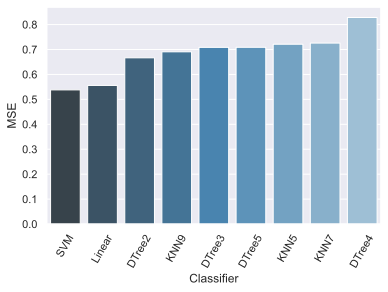

In [20]:
barplot = sns.barplot(data = results_df, x = 'Classifier', y = 'MSE', palette="Blues_d")
_ = barplot.set_xticklabels(barplot.get_xticklabels(), rotation=60)

In [21]:
results_df_train = pd.DataFrame(columns=['Classifier', 'MSE'])
def predict_and_add_to_df_train(data_frame, name, regressor):
    return data_frame.append({'Classifier': name, 'MSE': fit_predict_mse_train(regressor, train_x, train_y, test_x, test_y)}, ignore_index = True)
    
#results_df = results_df.append({'Classifier': 'NN', 'MSE': nn_mse(X,y)}, ignore_index = True)
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN5', KNeighborsRegressor(5))
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN7', KNeighborsRegressor(7))
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN9', KNeighborsRegressor(9))
results_df_train = predict_and_add_to_df_train(results_df_train, 'Linear', LinearRegression())
results_df_train = predict_and_add_to_df_train(results_df_train, 'SVM', SVR())
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree2', DecisionTreeRegressor(max_depth = 2))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree3', DecisionTreeRegressor(max_depth = 3))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree4', DecisionTreeRegressor(max_depth = 4))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree5', DecisionTreeRegressor(max_depth = 5))
results_df_train = results_df_train.sort_values(by = 'MSE').reset_index().drop(columns=['index'])
results_df_train

,Classifier,MSE
0,DTree5,0.087160
1,DTree4,0.180276
2,SVM,0.235620
3,DTree3,0.304583
4,KNN7,0.343765
5,KNN9,0.349572
6,KNN5,0.367792
7,Linear,0.394760
8,DTree2,0.427306


#  Train Set

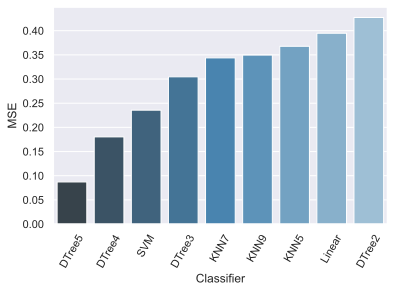

In [22]:
barplot = sns.barplot(data = results_df_train, x = 'Classifier', y = 'MSE', palette="Blues_d")
_ = barplot.set_xticklabels(barplot.get_xticklabels(), rotation=60)

In [12]:
inputs_len = len(X.columns)
input1 = Input(shape=(inputs_len,))
hidden1 = Dense(inputs_len, activation='relu')(input1)
hidden2 = Dense(inputs_len, activation='relu')(hidden1)
out1 = Dense(1)(hidden2)
model = Model(inputs=input1, outputs=out1)
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, y, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

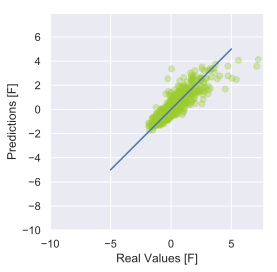

In [20]:
predicted = model.predict(X).flatten()
expected = y
plt.scatter(expected, predicted, alpha=.33, color='yellowgreen')
plt.xlabel('Real Values [F]')
plt.ylabel('Predictions [F]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,plt.xlim()[1]])
plt.ylim([-10,plt.ylim()[1]])
_ = plt.plot([-5, 5], [-5, 5])